In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm, LinearSegmentedColormap
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
from pyproj import Transformer
import xarray as xr

In [2]:
### Grab one WRF dataset to be able to reference its grid
dsn_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/final.zarr')

wrflons = dsn_hv['lon'].values
wrflats = dsn_hv['lat'].values
mean_lon = wrflons.mean()
mean_lat = wrflats.mean()

In [3]:
### Prepare map elements
coastline_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')

In [4]:
### Process shapefiles for lease areas
## Load shapefiles
# df_lease = gpd.read_file('/home/orybchuk/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
df_lease = gpd.read_file('/projects/olry2348/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
crs = ccrs.PlateCarree()

## Merge (aka dissolve) geometries by lease area
df_lease_group = df_lease.dissolve(by='LeaseNo_Co')
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Virginia')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Avangrid Renewables')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Oregon')] 
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Narragansett')]

In [5]:
### Process shapefiles for planning areas
## Load shapefiles
# df_plan = gpd.read_file('/home/orybchuk/shapefiles/BOEM_Wind_Planning_Areas_3_29_2021.shp')
df_plan = gpd.read_file('/projects/olry2348/shapefiles/BOEM_Wind_Planning_Areas_3_29_2021.shp')

# ## Convert projection to match what we use in Cartopy
# df_plan_proj = df_plan.to_crs(crs_proj4)

## Merge (aka dissolve) geometries by lease area
df_plan_group = df_plan.dissolve(by='INFO')
df_plan_group = df_plan_group[df_plan_group.index.str.startswith('New York')]

# df_plan_proj_group = df_plan_proj.dissolve(by='INFO')
# df_plan_proj_group = df_plan_proj_group[df_plan_proj_group.index.str.startswith('New York')]

In [6]:
# ### Read turbine data
turbine_file_vw = 'windturbines_vw.txt'
turbine_df_vw = pd.read_csv(turbine_file_vw, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])

turbine_file_full = 'windturbines_full.txt'
turbine_df_full = pd.read_csv(turbine_file_full, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])

In [7]:
### Pull key parameters out of turbine files
turb_lat_min_vw = turbine_df_vw['Lat'].min()
turb_lat_max_vw = turbine_df_vw['Lat'].max()
turb_long_min_vw = turbine_df_vw['Long'].min()
turb_long_max_vw = turbine_df_vw['Long'].max()

turb_lat_min_full = turbine_df_full['Lat'].min()
turb_lat_max_full = turbine_df_full['Lat'].max()
turb_long_min_full = turbine_df_full['Long'].min()
turb_long_max_full = turbine_df_full['Long'].max()

MAP_BOUNDS_turb_vw = [turb_long_min_vw-1, turb_long_max_vw+1, turb_lat_min_vw-1, turb_lat_max_vw+0.5]
MAP_BOUNDS_turb_full = [turb_long_min_full-1, turb_long_max_full+1, turb_lat_min_full-1, turb_lat_max_full+0.5]
MAP_BOUNDS_turb_big = [turb_long_min_full-5, turb_long_max_full+5, turb_lat_min_full-5, turb_lat_max_full+5]

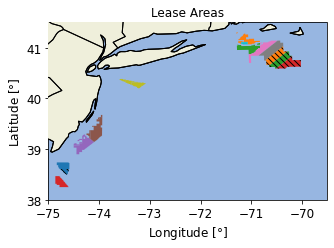

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection=proj))
ax.set_extent([-75, -69.5, 38, 41.5])
# ax.set_extent(MAP_BOUNDS_turb_full)
# ax.set_extent(MAP_BOUNDS_turb_big)

ax.set_yticks([38, 39, 40, 41])

# Ocean
ax.add_feature(ocean_50m, facecolor=cfeature.COLORS['water'], zorder=0, edgecolor='k')

# Land
ax.add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')

# States
ax.add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')

## Lease areas
LegendElement = []
for i in range(len(df_lease_group)):
    if i <= 9:
        ax.add_geometries([df_lease_group['geometry'].iloc[i]], 
                             crs=crs, edgecolor='None', facecolor="C"+str(i), linewidth=0.3, zorder=0)
        LegendElement.append(mpatches.Patch(facecolor='C'+str(i),
                                    label=df_lease_group.index[i]))
    else:
        ax.add_geometries([df_lease_group['geometry'].iloc[i]], 
                             crs=crs, edgecolor='None', facecolor="C"+str(i), linewidth=0.3, hatch='\\\\\\\\', zorder=0)
        LegendElement.append(mpatches.Patch(facecolor='C'+str(i),
                                    label=df_lease_group.index[i],
                                    hatch='\\\\\\\\'))
    
# ## Confirm that Dave's turbines are where they should be
# ax.scatter(turbine_df_full['Long'],
#               turbine_df_full['Lat'],
#               color='k',
#               zorder=101,
#               s=1)



ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=12)
ax.set_xlabel('Longitude [$\degree$]', fontsize=12)
ax.set_ylabel('Latitude [$\degree$]', fontsize=12)
    
# ax.legend(handles=LegendElement,loc='lower right')
ax.set_title("Lease Areas", fontsize=12)

# plt.savefig('../figs/domain.png', bbox_inches='tight', dpi=300)
# plt.savefig('../figs/domain.pdf', bbox_inches='tight')

plt.show()

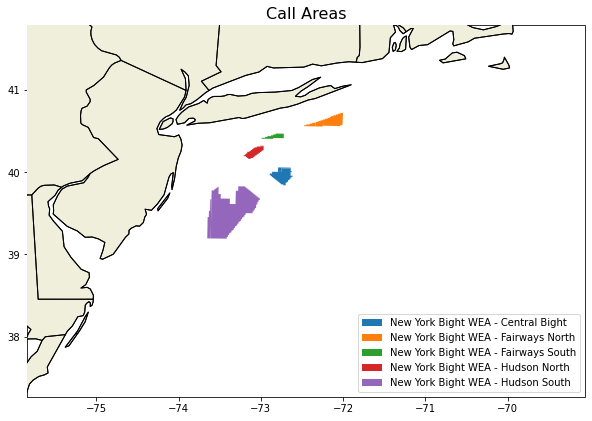

In [9]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=proj))
ax.set_extent(MAP_BOUNDS_turb_full)
# ax.set_extent(MAP_BOUNDS_turb_big)

# Land
ax.add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')

# States
ax.add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')

## Lease areas
LegendElement = []
for i in range(len(df_plan_group)):
    if i <= 9:
        ax.add_geometries([df_plan_group['geometry'].iloc[i]], 
                             crs=crs, edgecolor='None', facecolor="C"+str(i), linewidth=0.3)
        LegendElement.append(mpatches.Patch(facecolor='C'+str(i),
                                    label=df_plan_group.index[i]))
    else:
        ax.add_geometries([df_plan_group['geometry'].iloc[i]], 
                             crs=crs, edgecolor='None', facecolor="C"+str(i), linewidth=0.3, hatch='\\\\\\\\')
        LegendElement.append(mpatches.Patch(facecolor='C'+str(i),
                                    label=df_plan_group.index[i],
                                    hatch='\\\\\\\\'))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
    
ax.legend(handles=LegendElement,loc='lower right')
ax.set_title("Call Areas", fontsize=16)
plt.show()

### Calculate centroids

In [10]:
### Calculate centroids of all lease areas
## Calculate centroid in an equal area projection
lease_centroid_lat = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).y
lease_centroid_lon = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).x

df_lease_group['CentroidLat'] = lease_centroid_lat
df_lease_group['CentroidLon'] = lease_centroid_lon

## Calculate grid cell closest to centroid
lease_centroid_i = np.zeros_like(lease_centroid_lon)
lease_centroid_j = np.zeros_like(lease_centroid_lat)

for i in range(len(lease_centroid_lat)):
    centroid_dists = np.sqrt((wrflats - lease_centroid_lat[i])**2 \
                        + (wrflons - lease_centroid_lon[i])**2)

    this_j, this_i = np.unravel_index(np.argmin(centroid_dists, axis=None), centroid_dists.shape)
    
    lease_centroid_i[i], lease_centroid_j[i] = this_i, this_j
    
df_lease_group['CentroidI'] = lease_centroid_i.astype(int)
df_lease_group['CentroidJ'] = lease_centroid_j.astype(int)

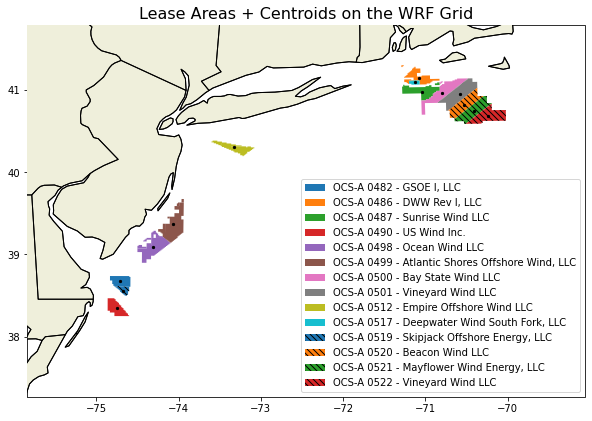

In [11]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=proj))
ax.set_extent(MAP_BOUNDS_turb_full)
# ax.set_extent(MAP_BOUNDS_turb_big)

# Land
ax.add_feature(land_50m, facecolor=cfeature.COLORS['land'], zorder=100, edgecolor='k')

# States
ax.add_feature(states_50m, facecolor='None', zorder=101, edgecolor='k')

## Lease areas
LegendElement = []
for i in range(len(df_lease_group)):
    if i <= 9:
        ax.add_geometries([df_lease_group['geometry'].iloc[i]], 
                             crs=crs, edgecolor='None', facecolor="C"+str(i), linewidth=0.3)
        LegendElement.append(mpatches.Patch(facecolor='C'+str(i),
                                    label=df_lease_group.index[i]))
    else:
        ax.add_geometries([df_lease_group['geometry'].iloc[i]], 
                             crs=crs, edgecolor='None', facecolor="C"+str(i), linewidth=0.3, hatch='\\\\\\\\')
        LegendElement.append(mpatches.Patch(facecolor='C'+str(i),
                                    label=df_lease_group.index[i],
                                    hatch='\\\\\\\\'))
    
## Confirm centroid locations
# # Physical location
# ax.scatter(df_lease_group['CentroidLon'],
#               df_lease_group['CentroidLat'],
#               color='k',
#               zorder=101,
#               s=5)

# Grid cell
for i in range(len(df_lease_group)):
    this_lat = dsn_hv['lat'].isel(west_east=df_lease_group['CentroidI'].iloc[i],
                                     south_north=df_lease_group['CentroidJ'].iloc[i]).values
    this_lon = dsn_hv['lon'].isel(west_east=df_lease_group['CentroidI'].iloc[i],
                                     south_north=df_lease_group['CentroidJ'].iloc[i]).values
    ax.scatter(this_lon,
                  this_lat,
                  color='k',
                  zorder=101,
                  s=5)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
    
ax.legend(handles=LegendElement,loc='lower right')
ax.set_title("Lease Areas + Centroids on the WRF Grid", fontsize=16)
plt.show()